In [1]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [2]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [3]:
log_reg.score(X_test, y_test)

0.7581863979848866

In [4]:
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

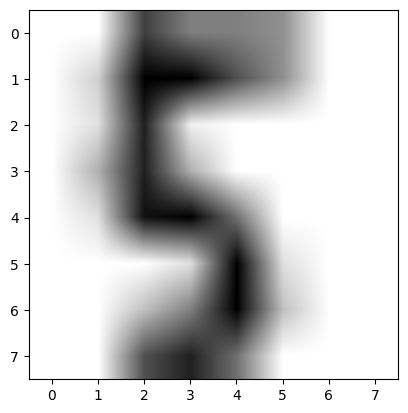

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X_train[25].reshape(8,8), cmap='binary', interpolation="bilinear")
plt.show()

In [6]:
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digits_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digits_idx]

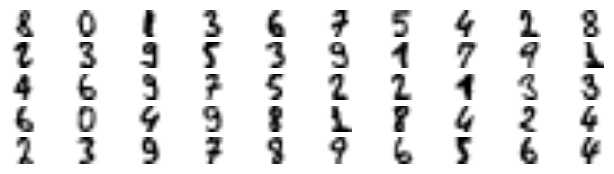

In [7]:
plt.figure(figsize=(8,2))
for index, X_representative_digit in enumerate(X_representative_digits):
  plt.subplot(k//10, 10, index+1)
  plt.imshow(X_representative_digit.reshape(8,8), cmap='binary', interpolation="bilinear")
  plt.axis("off")
plt.show()

In [8]:
import numpy as np

y_representative_digits = np.array([
    1, 9, 7, 0, 1, 6, 5, 6, 2, 4,
    3, 2, 9, 8, 5, 4, 1, 3, 8, 9,
    8, 4, 1, 0, 7, 7, 6, 5, 9, 3,
    4, 7, 1, 5, 1, 7, 8, 7, 9, 4,
    8, 2, 8, 2, 5, 6, 8, 9, 2, 6
])

In [9]:
y_representative_digits == y_train[representative_digits_idx]

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False])

In [10]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.15113350125944586

In [11]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
  y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [12]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.18639798488664988

In [13]:
percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]
print(len(y_train_partially_propagated))

1309


In [14]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.1889168765743073

In [15]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.16042780748663102

In [18]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Carregar o dataset MNIST
X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42
)

# Agrupamento Hierárquico
n_clusters = 50
agg = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agg.fit_predict(X_train)

# Encontrar os representantes de cada cluster
representative_indices = []
for cluster in range(n_clusters):
    cluster_samples = X_train[clusters == cluster]
    if len(cluster_samples) == 0:
        continue  # Caso raro: cluster vazio
    centroid = cluster_samples.mean(axis=0)
    distances = np.linalg.norm(cluster_samples - centroid, axis=1)
    idx_in_cluster = np.argmin(distances)
    idx_global = np.where(clusters == cluster)[0][idx_in_cluster]
    representative_indices.append(idx_global)

X_representative = X_train[representative_indices]
y_representative = y_train[representative_indices]


# Modelo com amostras do clustering
log_reg_cluster = LogisticRegression(max_iter=10_000)
log_reg_cluster.fit(X_representative, y_representative)
score_cluster = log_reg_cluster.score(X_test, y_test)

# Modelo com amostras aleatórias (50 exemplos)
np.random.seed(42)
random_indices = np.random.choice(len(X_train), size=50, replace=False)
X_random = X_train[random_indices]
y_random = y_train[random_indices]

log_reg_random = LogisticRegression(max_iter=10_000)
log_reg_random.fit(X_random, y_random)
score_random = log_reg_random.score(X_test, y_test)

# Modelo com dataset completo
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
score_full = log_reg_full.score(X_test, y_test)

# Resultados
print(f"Score com dataset completo: {score_full}")
print(f"Score com amostras do clustering: {score_cluster}")
print(f"Score com amostras aleatórias: {score_random}")

Score com dataset completo: 0.975
Score com amostras do clustering: 0.9361111111111111
Score com amostras aleatórias: 0.8388888888888889
